In [1]:
import json
from pathlib import Path

import numpy as np

from tqdm.notebook import tqdm
from ezmsg.util.messagelogger import MessageDecoder

from hololight.shallowfbcspnet import ShallowFBCSPNet, ShallowFBCSPParameters, balance_dataset

from typing import List


/Users/milsagw1/repos/git/hololight/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

samples = []
data_fname = Path( '..' ) / 'recordings' / 'traindata.txt'
with open( data_fname, 'r' ) as data_file:
    samples = [ json.loads( line, cls = MessageDecoder ) for line in data_file ]

eeg_trials = np.array( [ s[ 'sample' ][ 'data' ] for s in samples ] ).swapaxes( 1, 2 )
eeg_labels = np.array( [ int( s[ 'trigger' ][ 'value' ] ) for s in samples ] )

# Test single precision mode
eeg_trials = eeg_trials.astype( np.float32 )

In [3]:
from io import TextIOWrapper

class FileFBCSPDataset( FBCSPDataset ):
    
    # A preloaded dataset just stores the data in a tensor
    file: TextIOWrapper
    seekpoints: List[ int ]

    def __init__( self, filename: Path ) -> None:
        super().__init__()

        self.seekpoints = list()
        self.file = open( filename, 'r' )        
        while self.file.readable():
            seekpoint = self.file.tell()
            line = self.file.readline()
            if len( line ):
                self.seekpoints.append( seekpoint )
                obj = json.loads( line, cls = MessageDecoder )
                self.classes.append( int( obj[ 'trigger' ][ 'value' ] ) )
            else: break

    def get_trial( self, idx: int ) -> np.ndarray:  
        self.file.seek( self.seekpoints[ idx ] )
        obj = json.loads( self.file.readline(), cls = MessageDecoder )
        data: np.ndarray = obj[ 'sample' ][ 'data' ]
        return data

    def __del__( self ):
        self.file.close()

data_fname = Path( '..' ) / 'recordings' / 'traindata.txt'
dset = FileFBCSPDataset( data_fname )

NameError: name 'FBCSPDataset' is not defined

In [3]:
params = ShallowFBCSPParameters(
    in_chans = eeg_trials.shape[1],
    n_classes = len( np.unique( eeg_labels ) ),
    input_time_length = eeg_trials.shape[2],
    cropped_training = True,
    n_filters_time = 40,
    filter_time_length = 25,
    n_filters_spat = 40,
    pool_time_length = 75,
    pool_time_stride = 15,
    conv_nonlin = 'square',
    pool_mode = 'mean',
    pool_nonlin = 'safe_log',
    split_first_layer = True,
    batch_norm = True,
    batch_norm_alpha = 0.1,
    drop_prob = 0.5,
    single_precision = True
)

net = ShallowFBCSPNet( params )

print( net )

Model: Sequential(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 8), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 2, kernel_size=(30, 1), stride=(1, 1), dilation=(15, 1))
  (softmax): LogSoftmax(dim=1)
  (squeeze): Expression(expression=_squeeze_final_output)
)
Model has 16322 trainable parameters on device: cpu (cropped training)
When segmenting temporal windows -- use optimal temporal stride of 467 samples
Model input: ( batch x 8 ch x 1000 time points, dtype=torch.float32 )
Model output: ( batch x 2 classes x 467 crops, dtype=to

In [4]:
train_dset, test_dset = balance_dataset( ( eeg_trials, eeg_labels ), ( 0.8, 0.2 ) )
train_info = net.train( train_dset, test_dset, progress = True )

100%|██████████| 30/30 [00:15<00:00,  1.97it/s]


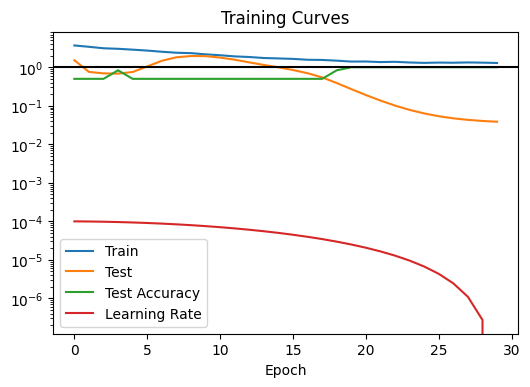

In [5]:
import matplotlib.pyplot as plt
from hololight.shallowfbcspnet import plot_train_info_mpl

fig, ax = plt.subplots( dpi = 100, figsize = ( 6.0, 4.0 ) )
plot_train_info_mpl( train_info, ax )

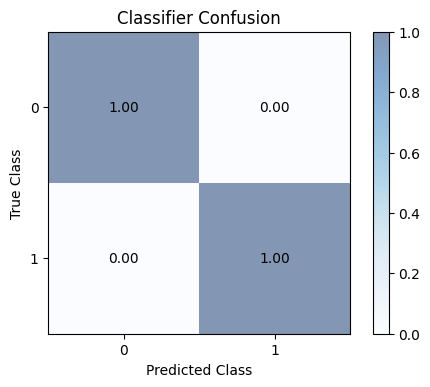

In [6]:
from hololight.shallowfbcspnet import plot_confusion_mpl

fig, ax = plt.subplots( dpi = 100 )
plot_confusion_mpl( net.confusion( test_dset ), ax )


In [7]:
checkpoint_fname = Path( '.' ) / 'TestFBCSP.checkpoint'
net.save_checkpoint_file( checkpoint_fname )

In [8]:
loaded_net = ShallowFBCSPNet.from_checkpoint_file( checkpoint_fname )

In [9]:
test_feats, test_labels = test_dset[:]
decode = net.inference( test_feats ).argmax( axis = 1 )
print( 'Decoded Output:')
print( decode )
print( 'True Output:' )
print( np.array( test_labels ) )

Decoded Output:
[0 0 1 1 0 1 1 0 0 1 0 1]
True Output:
[0 0 1 1 0 1 1 0 0 1 0 1]
